In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import io
import math 
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, factorial
from nilearn.glm.first_level.hemodynamic_models import _sample_condition, _resample_regressor, glover_hrf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from numpy.linalg import inv
%matplotlib inline


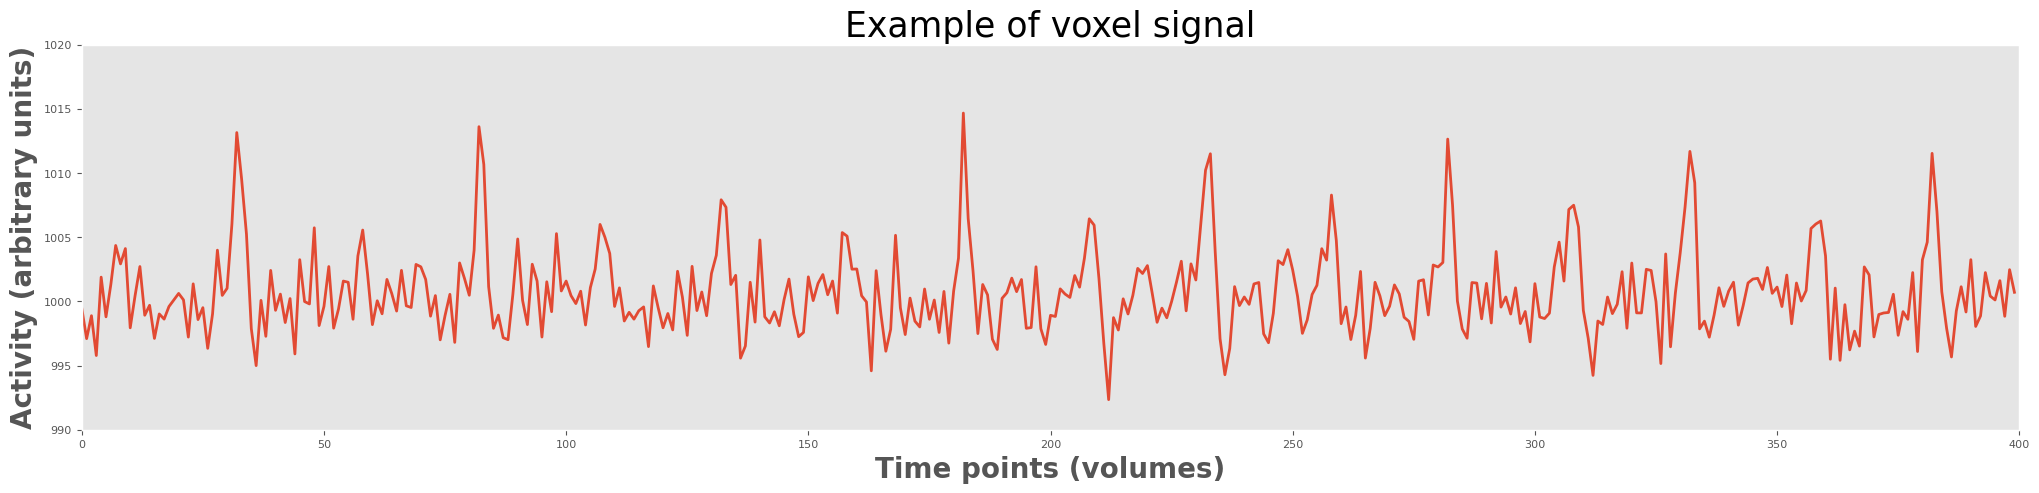

In [156]:
voxel_signal = np.load('example_voxel_signal.npy')
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
x_lim, y_lim = (0, 400), (990, 1020)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

In [157]:
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)
predictor_all = np.zeros(800)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

[ 10 110 210 310 410 510 610 710  60 160 260 360 460 560 660 760]


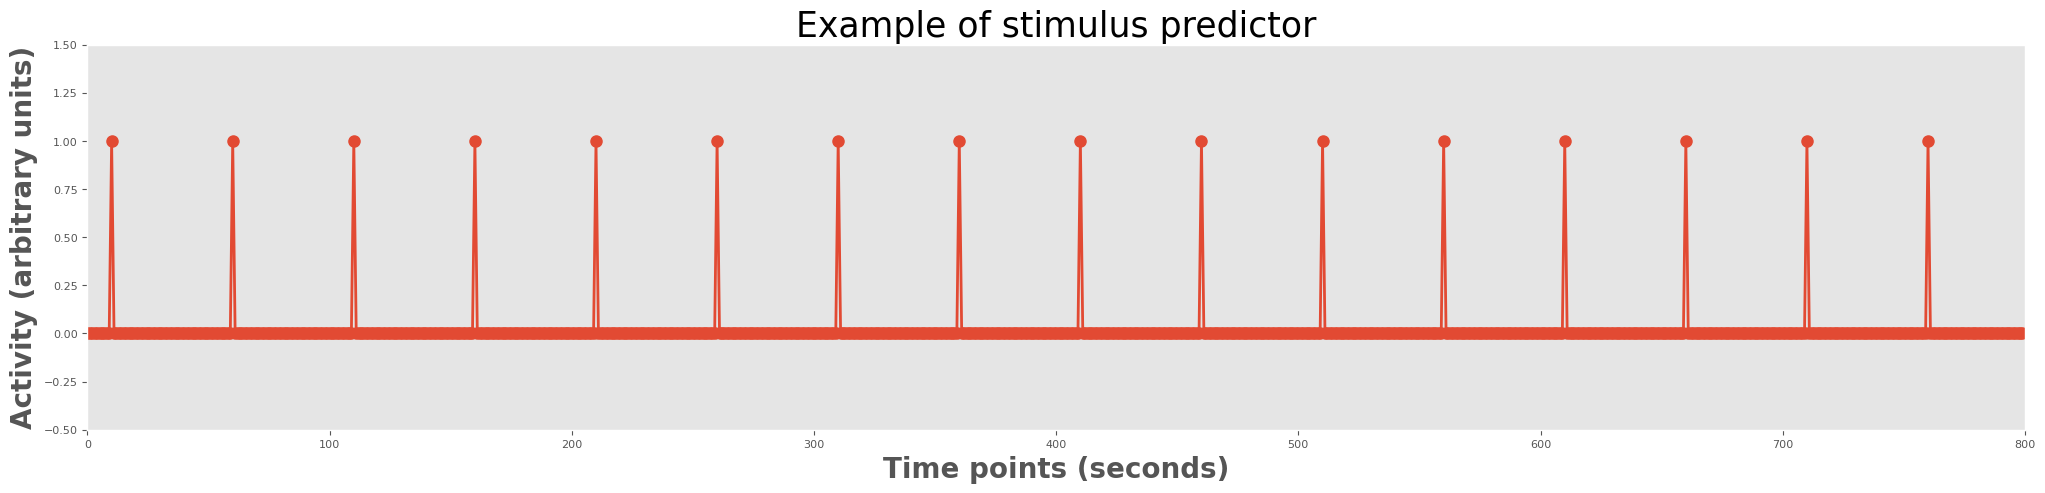

In [158]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 800)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

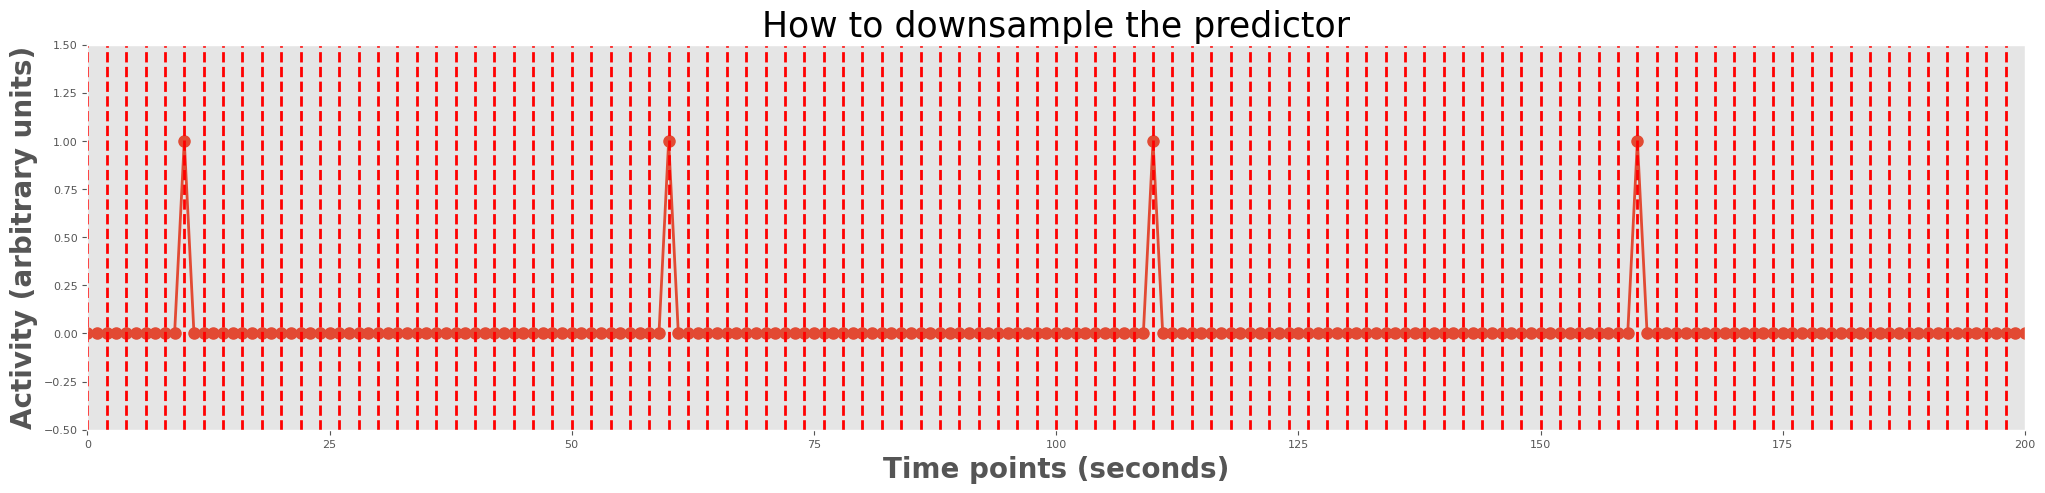

In [159]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=25)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

In [160]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 800, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-800, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 800, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 800, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 800 datapoints (0-800, in seconds)
Desired scale has 400 datapoints (0, 2, 4, ... 800, in volumes)
Downsampled predictor has 400 datapoints (in volumes)


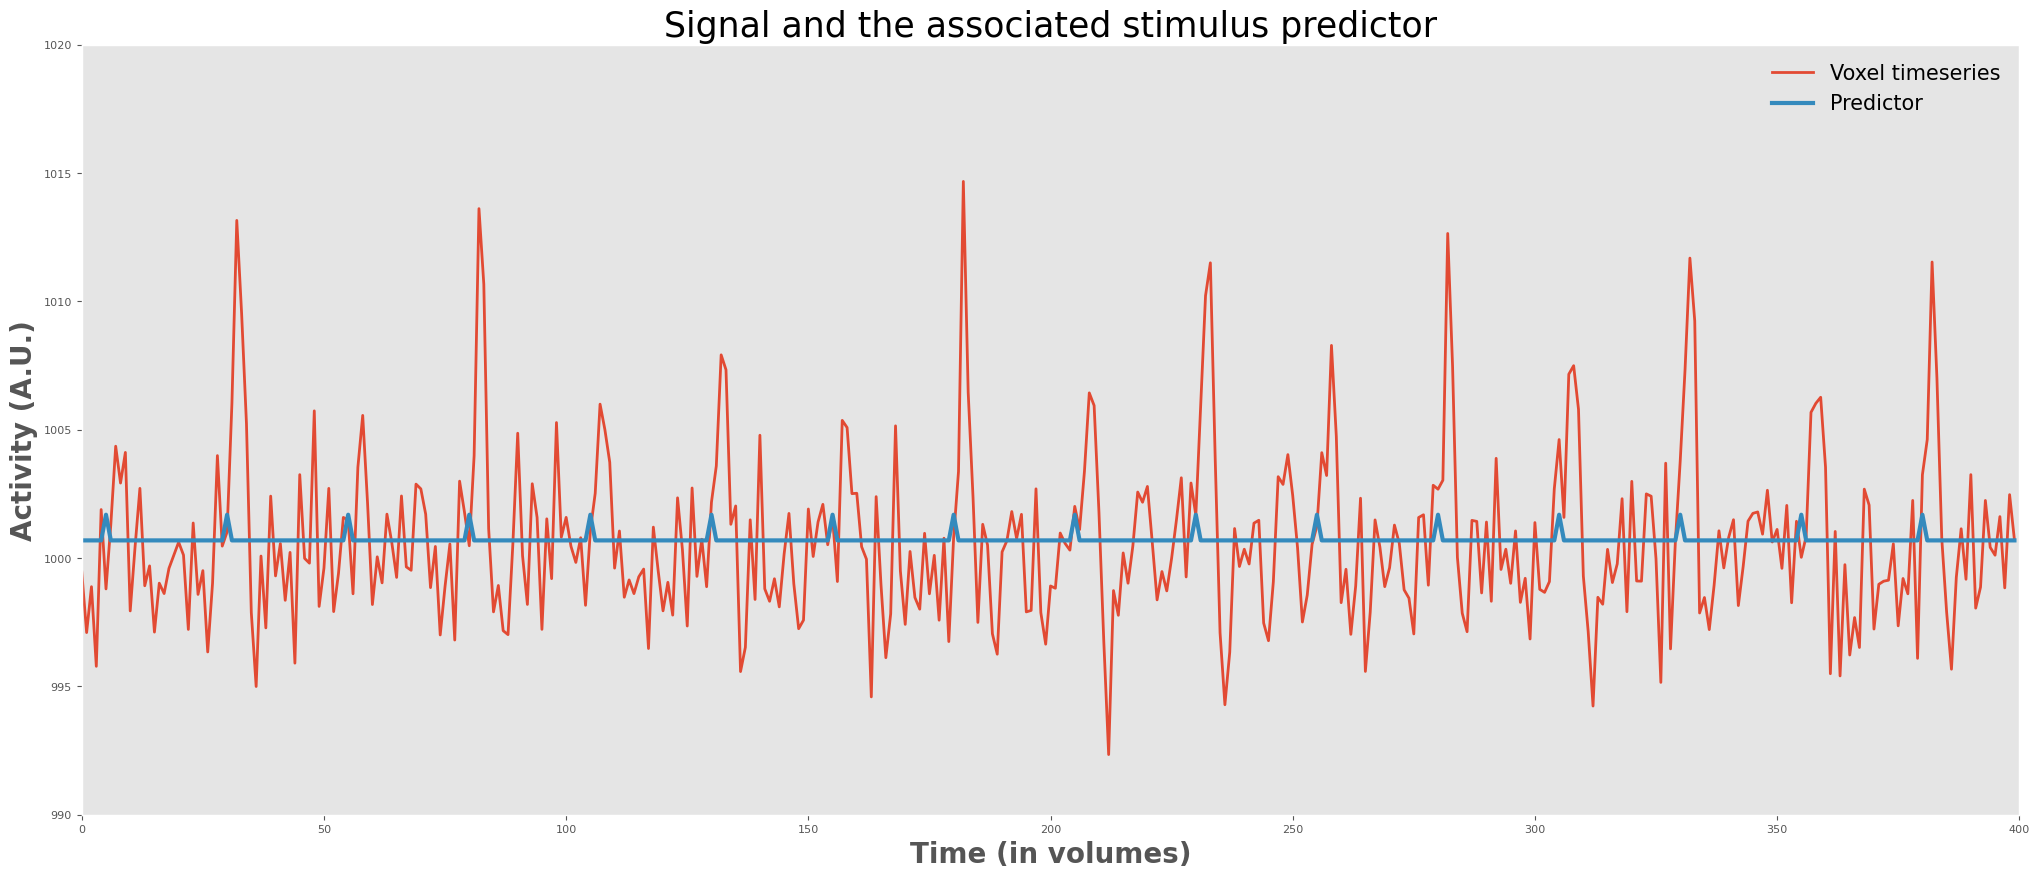

In [161]:
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(predictor_all_ds + voxel_signal.mean(), lw=3)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

In [162]:
if predictor_all_ds.ndim == 1:  # do not remove this! This adds a singleton dimension, such that you can call np.hstack on it
    predictor_all_ds = predictor_all_ds[:, np.newaxis]

icept = np.ones((predictor_all_ds.size, 1))
X_simple = np.hstack((icept, predictor_all_ds))

In [163]:
class hemodynamics():
    '''
    A class that has useful methods for handling hemodynamic response functions

    ...

    Methods
    -------
    hrf(self, alpha1, alpha2, beta1, beta2, c, t, A)
        Calculates the hemodynamic response function of a signal
    
    hrf_plotter(h, alpha1, alpha2)
        plots our hemodynamic response function signal dependent on alpha values
        
    '''

    def __init__(self):
        """
        Constructs all the necessary attributes for the hemodynamics object.

        Attributes
        ----------
            b1 : str
                beta1 constant used in hemodynamic response function
            b2 : str
                beta2 constant used in hemodynamic response function
            c : int
                c constant used in hemodynamic response function
        """
        self.b1 = 1
        self.b2 = 1
        self.c = 1/6

    def hrf(self, t, a1, a2, A):
        '''
        Calculates the hemodynamic response function of a signal

        :param a1:
        :param a2:
        :param b1:
        :param b2:
        :param c: 
        :param t: time
        :param A: amplitude
        
        :returns: the hemodynamic response function
        '''
        h = A * ((t**(a1 - 1) * self.b1**a1 * np.exp(-self.b1 * t))/gamma(a1) -
            self.c * (t**(a2 - 1) * self.b2**a2 * np.exp(-self.b2 * t)) / gamma(a2))
        return h

    def hrf_plotter(self, t, h, alpha1, alpha2, noise = False):
        '''
        plots our hemodynamic response function signal dependent on alpha values

        :param h: an array sequence that contains the hemodynamic signal
        :param t: time array
        :param h: hemodynamic response
        :param alpha1:
        :param alpha2:
        
        :returns: n/a
        '''
        # need to get x_ticks correct regardless of array size
        one = len(h)/3
        two = one*2
        three = one*3

        # plotting
        plt.rcParams['figure.figsize'] = (12, 2) 
        plt.plot(t,h, label='HRF Signal')
        plt.title("Hemodynamic Response function at α1: {} and α2: {}".format(alpha1, alpha2))
        plt.xlabel("time (s)")
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xticks()
        plt.yticks()
        if noise:
            conv_noisy = h + np.random.normal(0, 0.15, len(h))
            plt.plot(t, conv_noisy, label='HRF w/ Noise, σ=0.15')
            plt.xticks([0,one,two,three], ['0.0', '10.0','20.0', '30.0'])
            #plt.legend()
        plt.show()


    
    def hrf_alpha_plotter(self,t,alpha1, alpha2,A,alpha_value,upper,lower,jump):
        '''
        plots our hemodynamic response function signal dependent at multiple alpha values on the same plot

        :param t: time array
        :param alpha1: hrf 
        :param alpha2:
        :param A: amplitude
        :param alpha_value: input 1 or 2 to choose variability
        :param upper: upper limit of for loop
        :param lower: lower limit of for loop
        :param jump: jump variable in for loop
        
        :returns: n/a
        '''
        fig, ax = plt.subplots(figsize = (10, 5))
        for a in range(lower,upper,jump):
            if alpha_value == 1:
                ax.plot(t, self.hrf(t, a, alpha2, A), label=a)
            if alpha_value == 2:
                ax.plot(t, self.hrf(t, alpha1, a, A), label=a)
        ax.set_xlabel("time (s)")
        ax.set_ylabel('BOLD Signal [amplitude]')
        ax.set_title('Hemodynamic Response function at different α{} levels'.format(alpha_value))
        ax.grid(True)
        ax.legend(title='α{} values'.format(alpha_value))

In [164]:
# plot parameters for matplotlib to make nice R like plots
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 18 
plt.rcParams['xtick.labelsize'] = 8 
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [165]:
time_start=0
time_stop=32
t = np.linspace(time_start, time_stop, (time_stop - time_start)) # 100 msec resolution

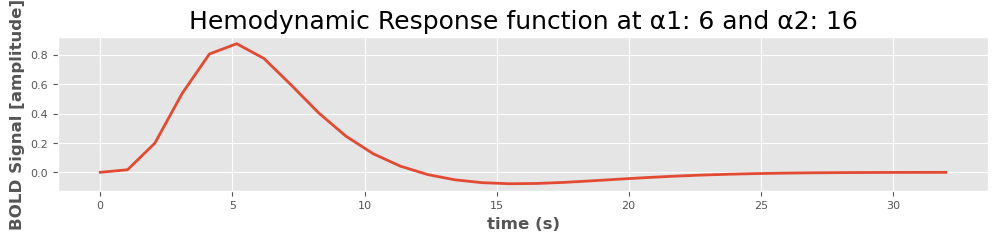

In [166]:
# custom variables 
alpha1=6 
alpha2=16
amplitude = 5

# creates our class object and runs functions
dynamics = hemodynamics()
h = dynamics.hrf(t, alpha1, alpha2, amplitude) # calls the hrf 
dynamics.hrf_plotter(t, h, alpha1, alpha2) # plots results

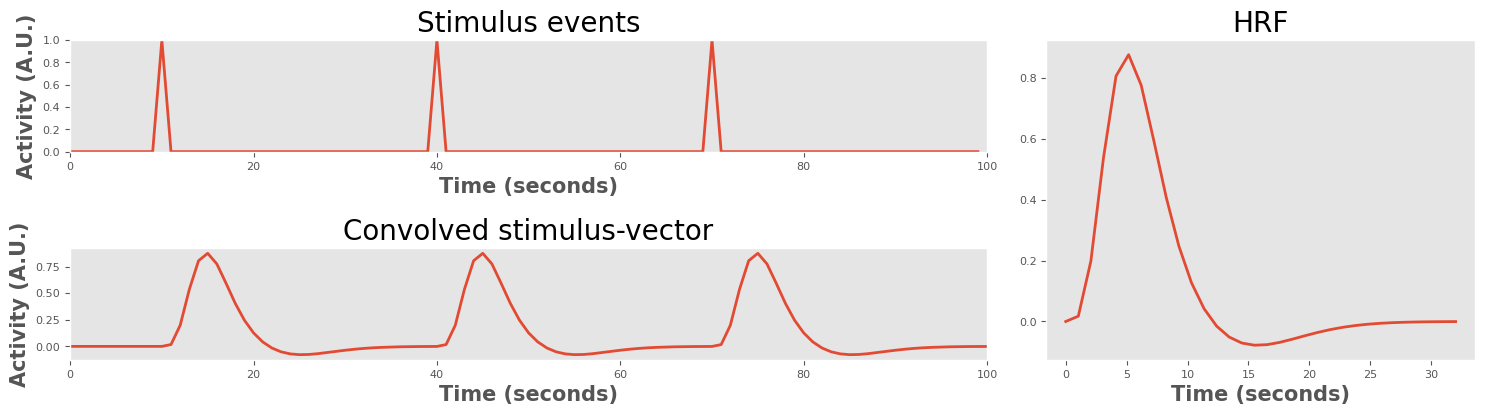

In [167]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(t, h)
plt.title('HRF', fontsize=20)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

convolved_stim_vector = np.convolve(random_stim_vector, h, 'full')
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

In [168]:
predictor_conv =np.array([np.convolve(predictor_all.squeeze(), h)[:predictor_all.size]])
print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

Shape after adding the new axis: (1, 800)


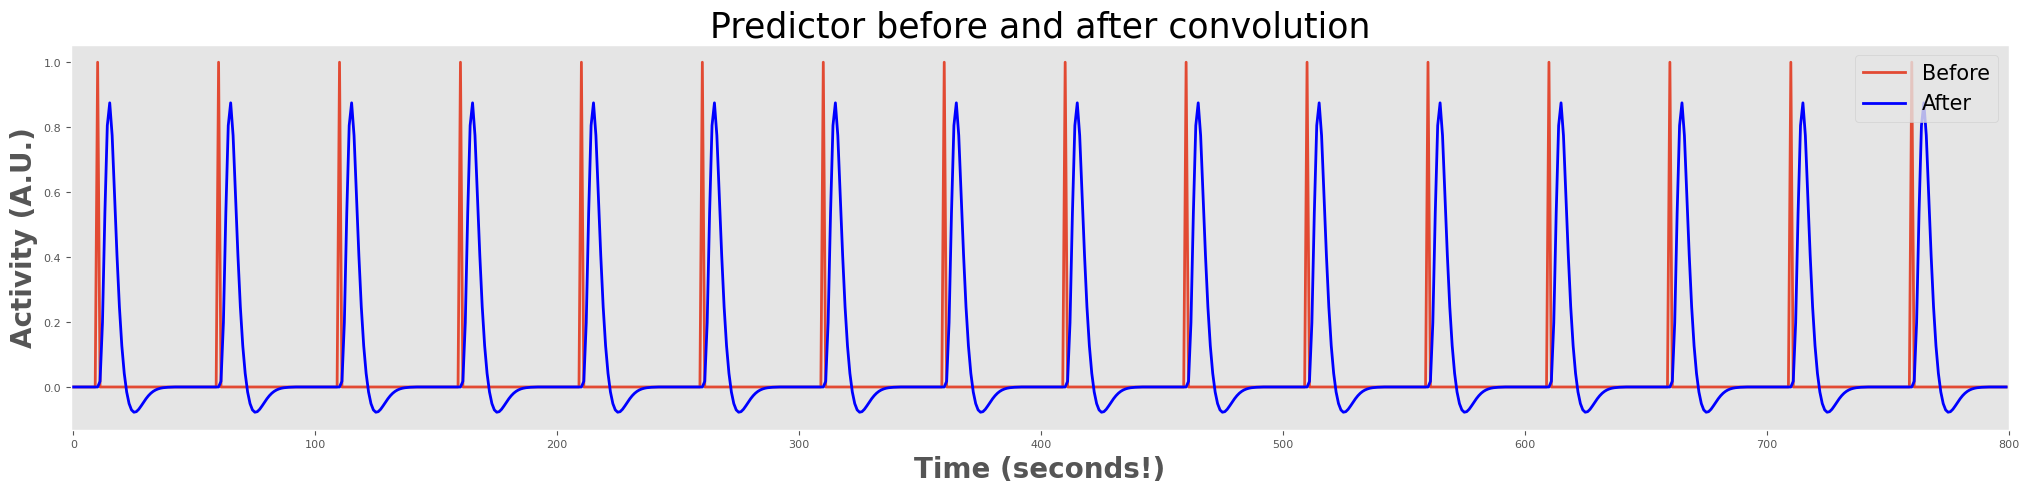

In [169]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv.T, color = 'b')
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

# Convolution can model any stimulus with hrf. Ignore steps..

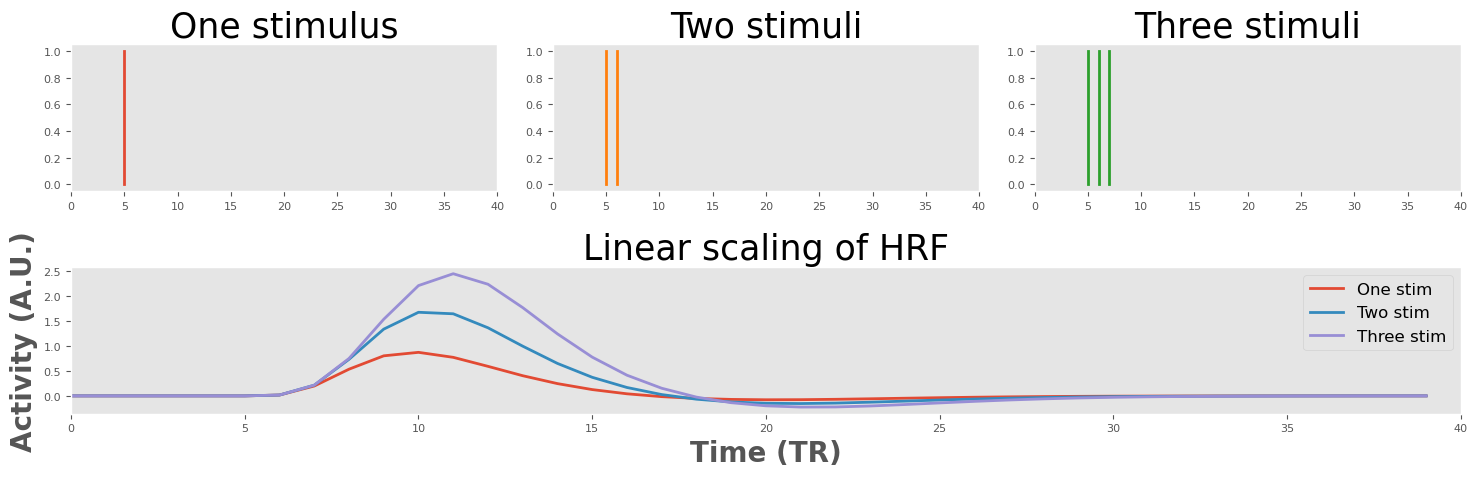

In [170]:
# linear scaling
plt.figure(figsize=(15, 5))

N = 40
one_stim = np.zeros(N)
one_stim[5] = 1
one_stim_conv = np.convolve(one_stim, h)[:N]
two_stim = np.zeros(N)
two_stim[[5, 6]] = 1
two_stim_conv = np.convolve(two_stim, h)[:N]
three_stim = np.zeros(N)
three_stim[[5, 6, 7]] = 1
three_stim_conv = np.convolve(three_stim, h)[:N]

plt.subplot2grid((2, 3), (0, 0))
for ons in np.where(one_stim)[0]:
    plt.plot([ons, ons], [0, 1])

plt.xlim(0, N)
plt.title("One stimulus", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 1))
for ons in np.where(two_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:orange')

plt.xlim(0, N)
plt.title("Two stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 2))
for ons in np.where(three_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:green')

plt.xlim(0, N)    
plt.title("Three stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (1, 0), colspan=3)
plt.plot(one_stim_conv)
plt.plot(two_stim_conv)
plt.plot(three_stim_conv)
plt.legend(['One stim', 'Two stim', 'Three stim'])
plt.title('Linear scaling of HRF', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (TR)', fontsize=20)
plt.xlim(0, N)
plt.grid()
plt.tight_layout()
plt.show()

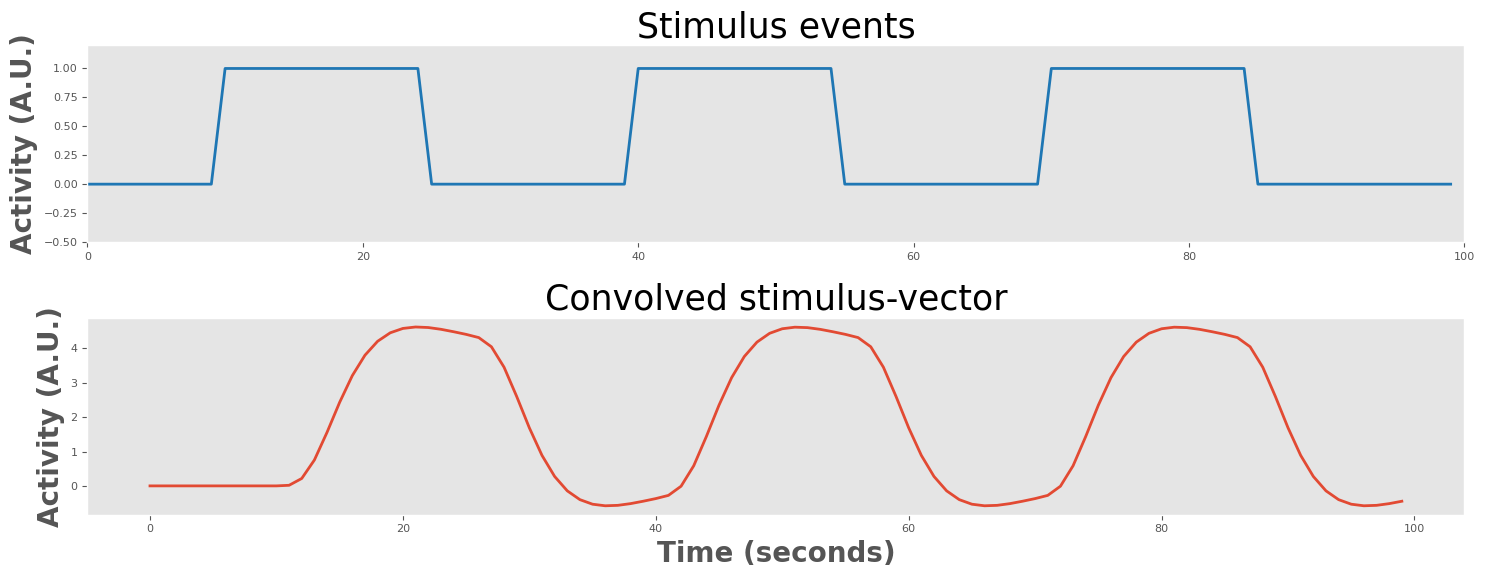

In [171]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=20)

plt.title('Stimulus events', fontsize=25)

convolved_stim_vector2 = np.convolve(random_stim_vector2, h)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

/var/folders/q3/z0pdr58n4bn46rs6tvs5t1y00000gn/T/ipykernel_17062/579429785.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot((i, i), (0, 1), 'k-', c='tab:blue')


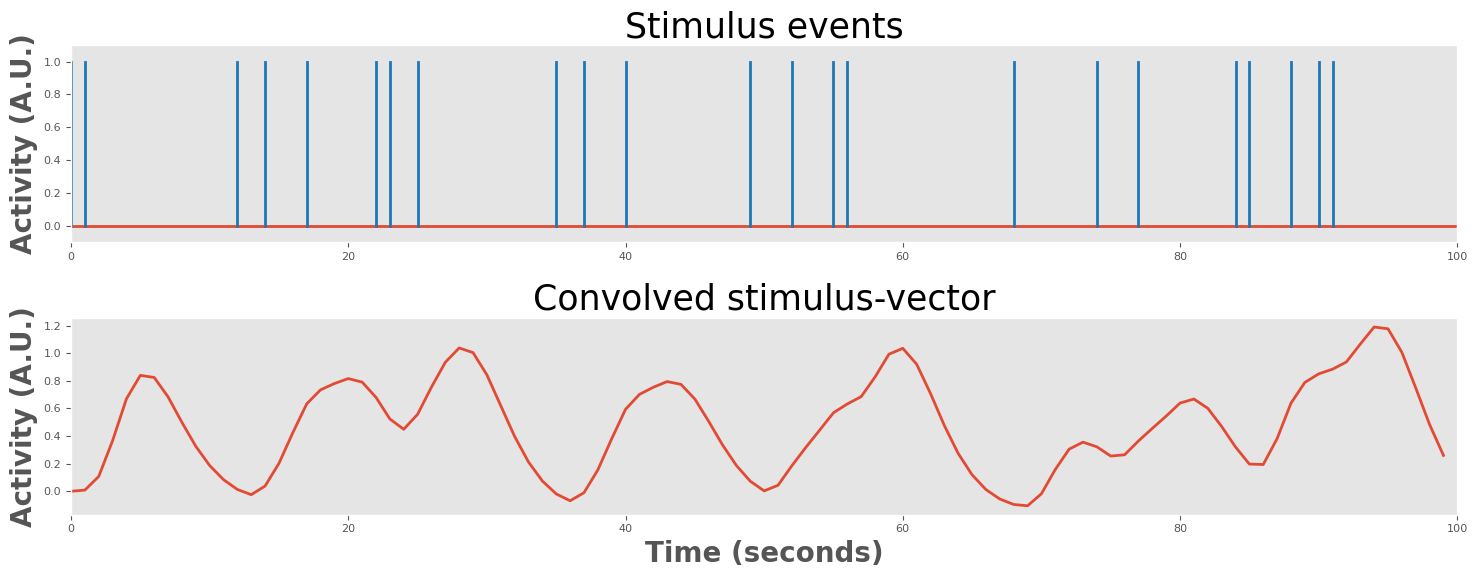

In [172]:
random_stimulus_onsets3 = np.random.randint(0, 100, 25)
random_stim_vector3 = np.zeros(100)
random_stim_vector3[random_stimulus_onsets3] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), 'k-', c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.title('Stimulus events', fontsize=25)
plt.grid()

convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, h, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

In [173]:
print("Size convolved predictor: %i" % predictor_conv.size)
print("Size voxel signal: %i" % voxel_signal.size)

Size convolved predictor: 800
Size voxel signal: 400


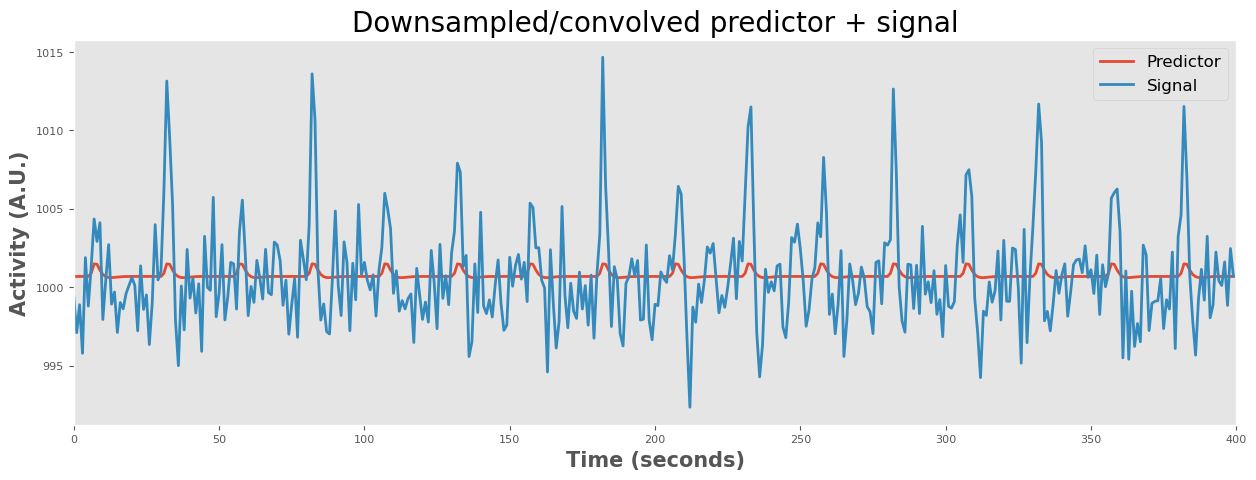

In [174]:
original_scale = np.arange(0, 800)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 800, 2)
predictor_conv_ds = resampler(desired_scale)

plt.figure(figsize=(15, 5))
plt.plot(predictor_conv_ds + voxel_signal.mean())
plt.plot(voxel_signal)
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['Predictor', 'Signal'])
plt.xlim(x_lim)
plt.show()

# millisecond precision (50 seconds data

In [175]:
onsets2 = np.array([3.62, 16.26, 34.12, 42.98])  # in seconds
duration = 50  # duration experiment in seconds
osf = 100  # osf = OverSampling Factor

pred2 = np.zeros(duration * osf)
print("Size of oversampled (factor: 1000) predictor: %i" % pred2.size)

onsets2_in_msec = (onsets2 * osf).astype(int)  # we convert it to int, because floats (even when it's 5.0) cannot be used as indices
pred2[onsets2_in_msec] = 1

Size of oversampled (factor: 1000) predictor: 5000


In [176]:
time_start=0
time_stop=32
t = np.linspace(time_start, time_stop, (time_stop - time_start)*100) # 100 msec resolution
print(t.shape)

(3200,)


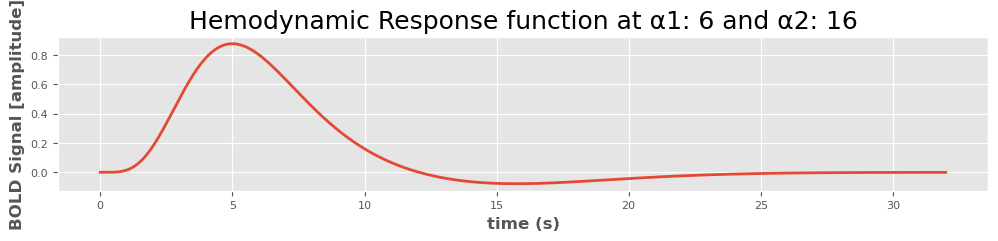

In [177]:
# custom variables 
alpha1=6 
alpha2=16
amplitude = 5

# creates our class object and runs functions
dynamics = hemodynamics()
h = dynamics.hrf(t, alpha1, alpha2, amplitude) # calls the hrf 
dynamics.hrf_plotter(t, h, alpha1, alpha2) # plots results

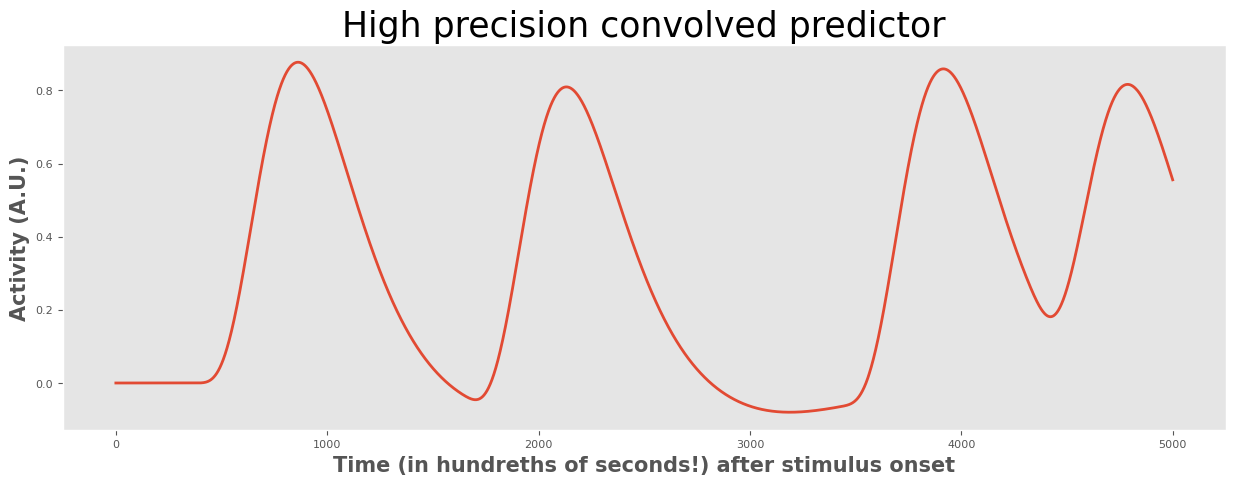

In [178]:
pred2_conv = np.convolve(pred2, h)[:pred2.size]

plt.figure(figsize=(15, 5))
plt.plot(pred2_conv)
plt.xlabel('Time (in hundreths of seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('High precision convolved predictor', fontsize=25)
plt.grid()
plt.show()

(400,)
(400, 1)


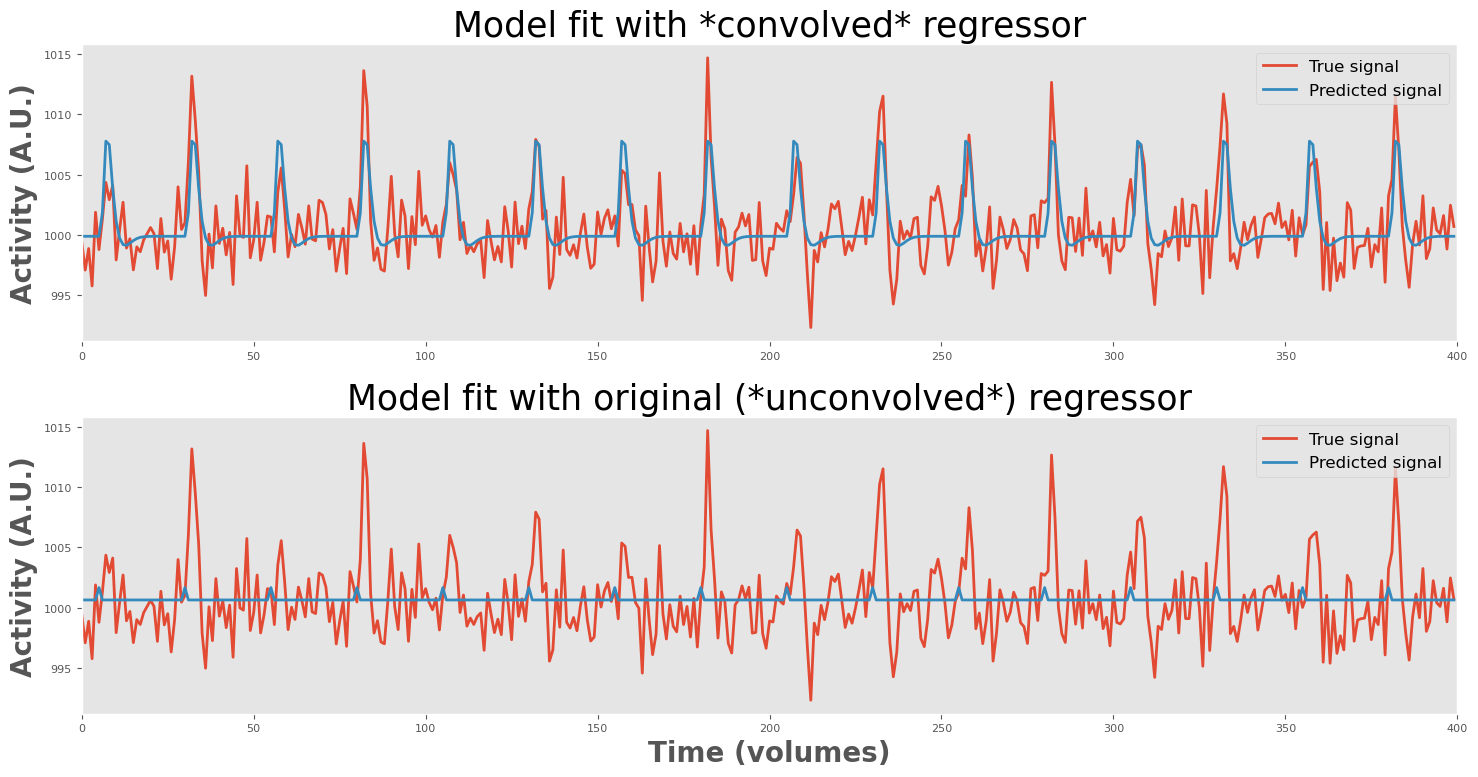

In [179]:
print(voxel_signal.shape)
if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]

print(predictor_conv_ds.shape)

intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv @ betas_conv, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
betas_simple = np.array([1000.64701684, 1.02307437])
plt.plot(X_simple @ betas_simple, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

In [180]:
print(betas_conv)

[999.89716282   9.78735907]


In [181]:
from numpy.linalg import lstsq  # numpy implementation of OLS, because we're lazy

y_hat_conv = X_conv @ betas_conv
y_hat_orig = X_simple @ lstsq(X_simple, voxel_signal, rcond=None)[0]

MSE_conv = ((y_hat_conv - voxel_signal) ** 2).mean()
MSE_orig = ((y_hat_orig - voxel_signal) ** 2).mean()

print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f." %
     (MSE_conv, MSE_orig))

R2_conv = 1 - (np.sum((voxel_signal - y_hat_conv) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
R2_orig = 1 - (np.sum((voxel_signal - y_hat_orig) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))

print("R-squared of model with convolution is %.5f and without convolution it is %.5f." % 
     (R2_conv, R2_orig))

MSE of model with convolution is 5.307 while the MSE of the model without convolution is 10.327.
R-squared of model with convolution is 0.48816 and without convolution it is 0.00388.


In [182]:
predictor_circles = np.zeros(800)
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros(800)
predictor_squares[onsets_squares] = 0.5
print(predictor_circles.shape)

(800,)


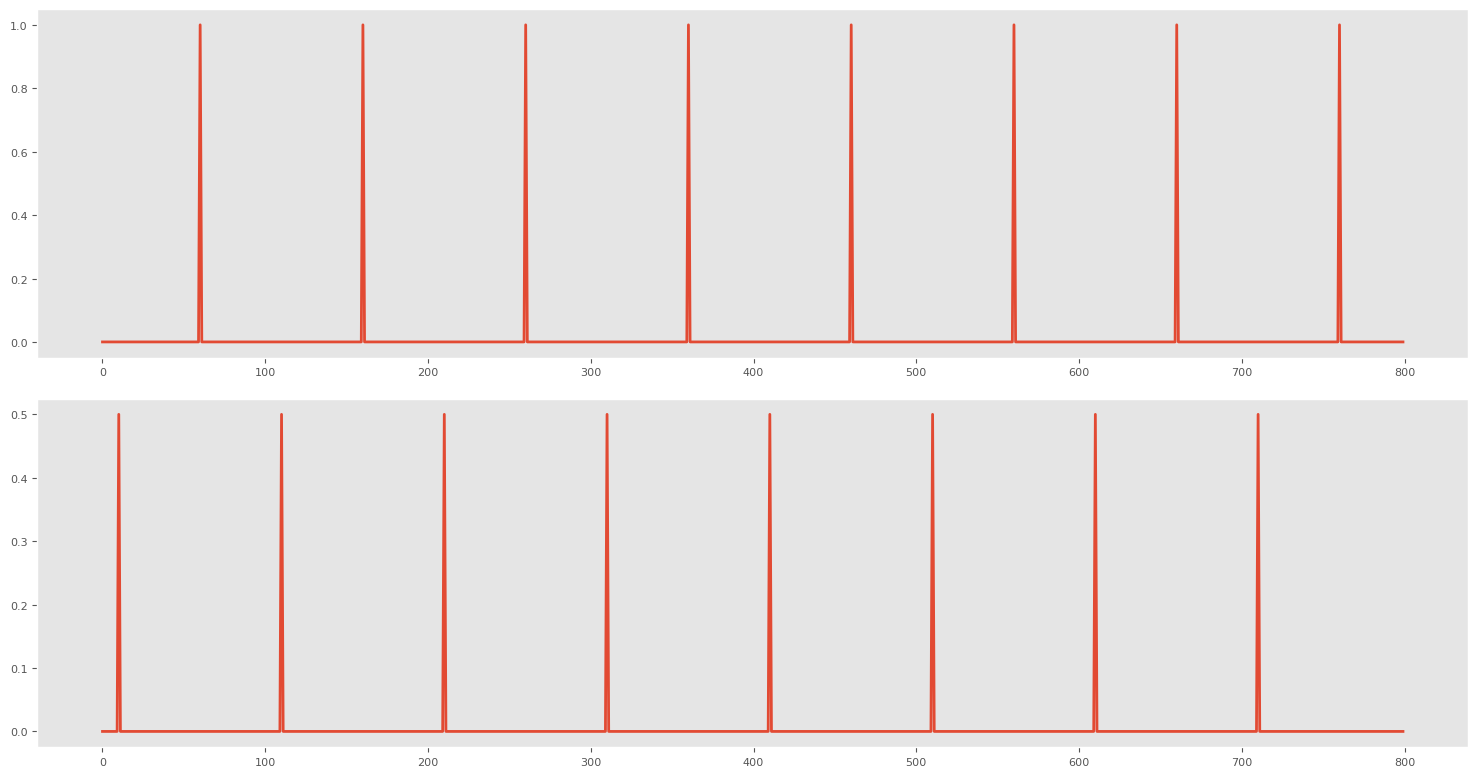

In [183]:

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(predictor_circles)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(predictor_squares)
plt.grid()

plt.tight_layout()
plt.show()

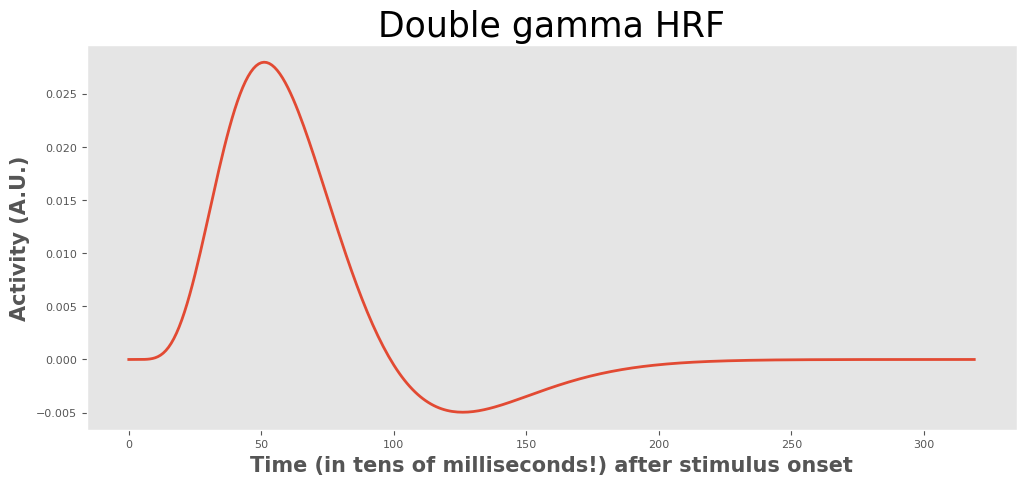

In [184]:
osf = 10 * 2
hrf_ms = glover_hrf(tr=2, oversampling=osf, time_length=32)
# hrf_ms /= hrf_ms.max()  # scale such that max = 1

t = np.arange(0, hrf_ms.size)

plt.figure(figsize=(12, 5))
plt.plot(t, hrf_ms)
plt.xlabel('Time (in tens of milliseconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

(800, 1)
(800, 1)


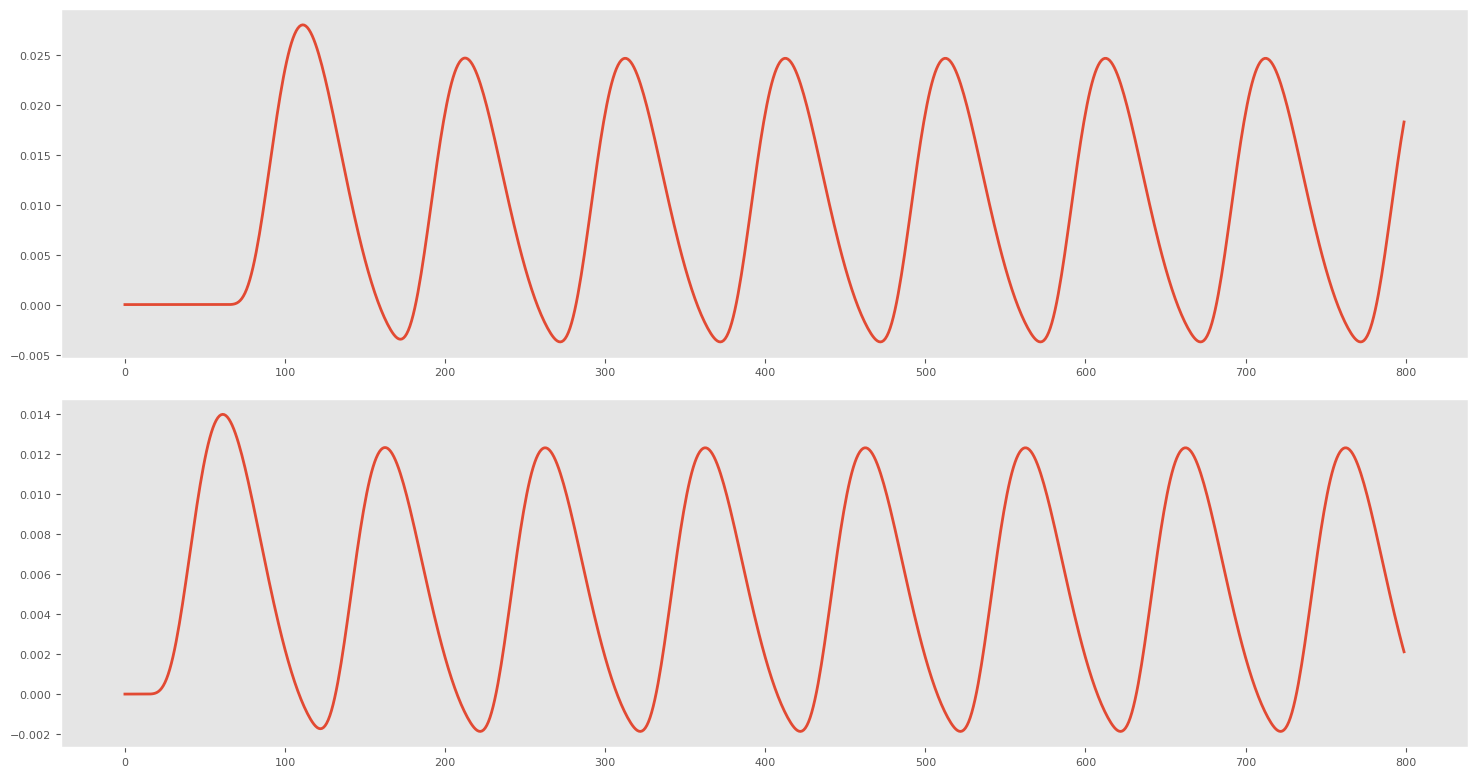

In [185]:
circles = np.convolve(predictor_circles, hrf_ms)[:predictor_circles.size]
squares = np.convolve(predictor_squares, hrf_ms)[:predictor_squares.size]
circles = circles[:, np.newaxis]
squares = squares[:, np.newaxis]
print(circles.shape)
print(squares.shape)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(circles)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(squares)
plt.grid()

plt.tight_layout()
plt.show()


The shape of the convolved predictor after convolution: (1119,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


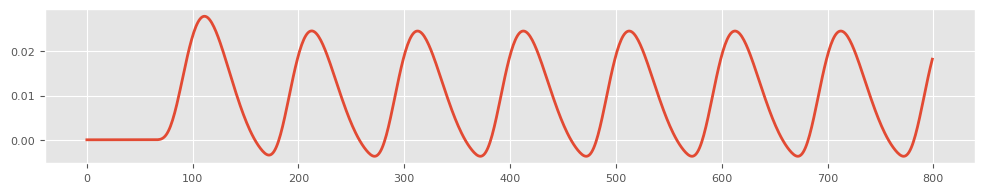

In [186]:
circles_var = np.convolve(predictor_circles, hrf_ms)
print("The shape of the convolved predictor after convolution: %s" % (circles_var.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
circles_var= circles_var[:predictor_circles.size]

print("After trimming, the shape is: %s" % (circles_var.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
circles_var = circles_var[:, np.newaxis]

print("Shape after adding the new axis: %s" % (circles_var.shape,))
plt.plot(circles_var)

The shape of the convolved predictor after convolution: (1119,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


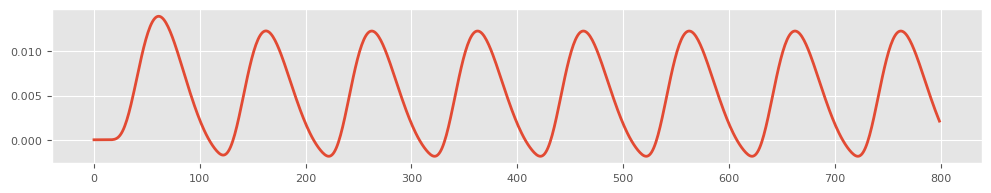

In [187]:
squares_var = np.convolve(predictor_squares, hrf_ms)
print("The shape of the convolved predictor after convolution: %s" % (squares_var.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
squares_var = squares_var[:predictor_squares.size]

print("After trimming, the shape is: %s" % (squares_var.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
squares_var = squares_var[:, np.newaxis]

print("Shape after adding the new axis: %s" % (squares_var.shape,))
plt.plot(squares_var)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 1)
[[1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 ...
 [1.         0.01630277 0.00271231]
 [1.         0.01730577 0.00240942]
 [1.         0.01825813 0.00211491]]
[-0.02368319  1.02472453  4.67074153]
[-0.02368319  1.02472453  4.67074153]
[ 1.41457861e-04  5.82956377e-01 -1.04146385e-01]


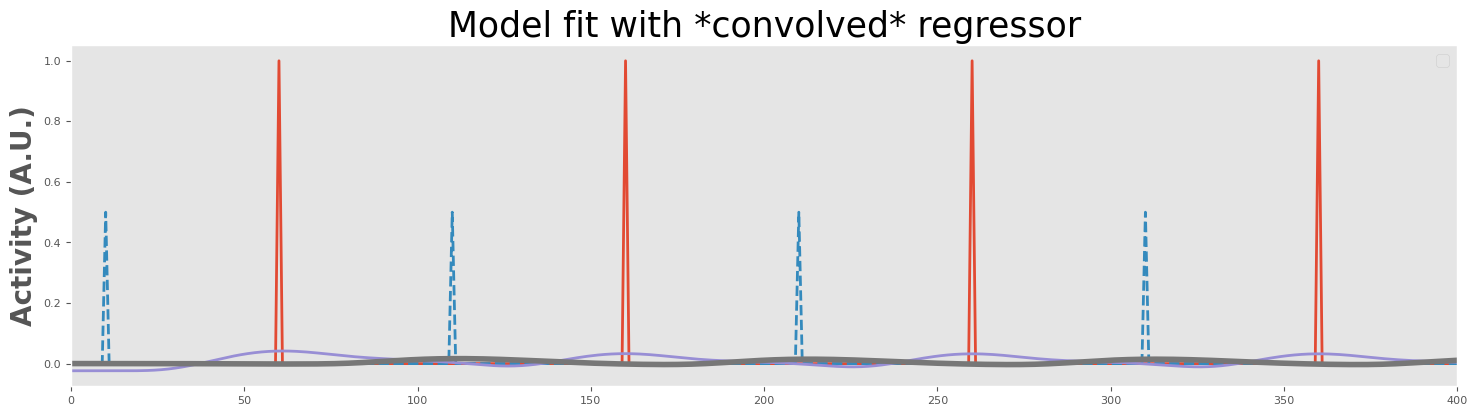

In [188]:
print(circles.shape)

intercept = np.ones((circles.size, 1))
X_conv = np.hstack((intercept, circles, squares))
print(X_conv)
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ predictor_circles
print(betas_conv)
betas_conv2 = inv(X_conv.T @ X_conv) @ X_conv.T @ predictor_squares
print(betas_conv)
print(betas_conv2)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(predictor_circles)
plt.plot(predictor_squares, '--')
plt.plot(X_conv @ betas_conv, lw=2)
plt.plot(X_conv @ betas_conv2, lw=4)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()